Test MAE: 2.92


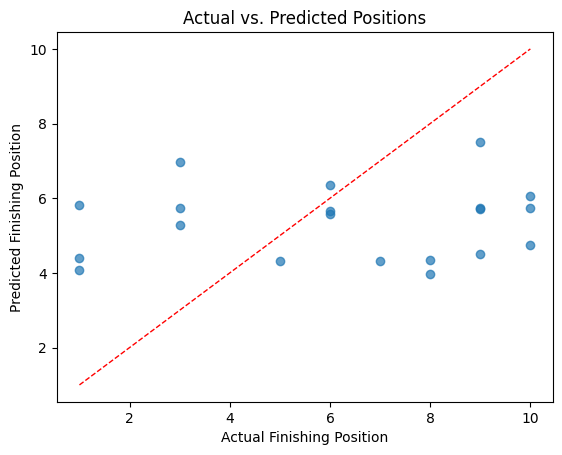

Saved model → ranker_model.joblib
Saved scaler → scaler.joblib
Dummy Data MAE: 3.07

Dummy Input Results:
   points  total_wins  finishing_position  predicted_position
0    1200           2                   3                   6
1    1500           4                   1                   7
2     900           0                   5                   5


In [4]:
# full_pipeline_with_dummy_test.py

import pandas as pd
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def load_data(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def preprocess(df: pd.DataFrame):
    X = df[['points', 'best_lap_time', 'total_wins']].copy()
    X['inv_lap_time'] = -X.pop('best_lap_time')
    y = df['finishing_position']
    return X, y

def train_model(X_train, y_train):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    return model, scaler

def evaluate_model(model, scaler, X_test, y_test):
    X_test_scaled = scaler.transform(X_test)
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    print(f"Test MAE: {mae:.2f}")
    return preds

def plot_results(y_test, preds):
    plt.figure()
    plt.scatter(y_test, preds, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=1)
    plt.xlabel('Actual Finishing Position')
    plt.ylabel('Predicted Finishing Position')
    plt.title('Actual vs. Predicted Positions')
    plt.show()

def save_artifacts(model, scaler,
                   model_path='ranker_model.joblib',
                   scaler_path='scaler.joblib'):
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    print(f"Saved model → {model_path}")
    print(f"Saved scaler → {scaler_path}")

def test_with_dummy(model_path, scaler_path):
    # 1) load saved artifacts
    model  = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # 2) define some dummy inputs (with known finishing_position)
    dummy = pd.DataFrame([
        {'points': 1200, 'best_lap_time': 141.0, 'total_wins': 2, 'finishing_position': 3},
        {'points': 1500, 'best_lap_time': 139.5, 'total_wins': 4, 'finishing_position': 1},
        {'points':  900, 'best_lap_time': 145.2, 'total_wins': 0, 'finishing_position': 5},
    ])

    # 3) preprocess dummy
    X_dummy = dummy[['points', 'best_lap_time', 'total_wins']].copy()
    X_dummy['inv_lap_time'] = -X_dummy.pop('best_lap_time')
    y_dummy = dummy['finishing_position']

    # 4) scale & predict
    Xd_scaled = scaler.transform(X_dummy)
    y_pred = model.predict(Xd_scaled)

    # 5) evaluate on dummy
    mae_dummy = mean_absolute_error(y_dummy, y_pred)
    print(f"Dummy Data MAE: {mae_dummy:.2f}")

    # 6) show comparison
    dummy['predicted_position'] = np.round(y_pred).astype(int)
    print("\nDummy Input Results:")
    print(dummy[['points','total_wins','finishing_position','predicted_position']])

def main():
    # ——— 1) Load & preprocess real data ———
    df = load_data('season_data.csv')
    X, y = preprocess(df)

    # ——— 2) split ———
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # ——— 3) train ———
    model, scaler = train_model(X_train, y_train)

    # ——— 4) evaluate on hold-out ———
    preds = evaluate_model(model, scaler, X_test, y_test)

    # ——— 5) visualize ———
    plot_results(y_test, preds)

    # ——— 6) save artifacts ———
    save_artifacts(model, scaler)

    # ——— 7) load artifacts & test dummy inputs ———
    test_with_dummy('ranker_model.joblib', 'scaler.joblib')

if __name__ == '__main__':
    main()
